# Fundamental diagrams of pedestrian flow from empirical video data

## Author
Étienne Beauchamp  
M.A.Sc. candidate, Department of Civil, Geological and Mining Engineering  
Polytechnique Montréal, C.P. 6079, succ. Centre-Ville  
Montréal (Québec) Canada H3C 3A7  
Phone: (514) 340-4711 ext. 4210  
Email: etienne-2.beauchamp@polymtl.ca

## Overview
This code was written for a project done as part of the course *CIV6705 - Théorie de la circulation*. It uses methods from the TrafficIntelligence Python module to draw fundamental diagrams of pedestrian data extracted from video recordings.

Before getting started, you will need to install the following:
* Python 3.5.6 (other versions were not tested) with most of the standard scientific packages (e.g., numpy, matplotlib, pandas, etc.). I recommend installing [Anaconda](https://www.anaconda.com/download/#linux);
* [TrafficIntelligence](https://bitbucket.org/Nicolas/trafficintelligence/wiki/Home);
* [OpenCV 3.4.3](https://anaconda.org/conda-forge/opencv).

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib as mpl

from trafficintelligence import storage, moving, cvutils, utils, metadata
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point, Polygon
from shapely.prepared import prep
from matplotlib import cm, pyplot

In [2]:
objects = storage.loadTrajectoriesFromSqlite('Donnees/1014AM_July 11_2014(E to W).sqlite','feature',2000)

In [3]:
frameRate = 30

# Limits of the study area
min_x = 9.45423
max_x = 31.3422
min_y = 7.99941
max_y = 26.8535

limits   = [[12.7377, min_y], [min_x, 20.4617], [26.2292, max_y], [max_x, 19.6558]]
limitBox = Polygon(limits)

Text(0,0.5,'y axis position (m)')

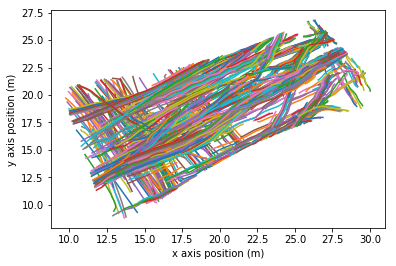

In [4]:
for o in objects:
    o.plot()

pyplot.xlabel('x axis position (m)')
pyplot.ylabel('y axis position (m)')
# pyplot.savefig('Donnees/Donnees_produites/Figures/trajectoires_pre-filtering.eps', format='eps')

### Data filtering

In [5]:
def createMetadata(session, dirname = './'):
    site = metadata.Site('nyc/penn-station', 'NYC 7th avenue south crosswalk at 32nd west', 40.749696,-73.9913135, 
                         'world.png', 0.05618, worldDistanceUnit='m') # 5. m /89 pixels
    session.add(site)
    heroCamera = metadata.CameraType('GoPro 3+ Black', 1920, 1080, 29.97, 's', intrinsicCameraFilename = '/home/nicolas/Research/Data/calibration-cameras/hero3+-black-1080-wide-lee/intrinsic-camera.txt', distortionCoefficients = [-0.160, 0.018, 0.00030756, -0.00020578, -0.00091816])
    session.add(heroCamera)
    cameraView = metadata.CameraView('E to W', dirname+'homography.txt', site, heroCamera, dirname+'tracking.cfg', dirname+'mask.png')
    session.add(cameraView)
    filenames = utils.listfiles(dirname+'.', 'MP4')
    print(filenames)
    startTime = datetime.strptime('2014-07-11 10:14:57', utils.datetimeFormat) # guess for the seconds, to fit the other times
    duration = timedelta(seconds = float(nFrames)/frameRate)
    for f in filenames:
        session.add(metadata.VideoSequence(f, startTime, duration, cameraView, utils.removeExtension(f)+'.sqlite'))
        startTime += duration
    session.commit()

In [6]:
dirname = './'
metaDBFilename = dirname+"metadata-nyc.sqlite"
session = metadata.connectDatabase(metaDBFilename)
site = metadata.getSite(session, name = 'nyc')[0]
cameraView = session.query(metadata.CameraView).filter(metadata.CameraView.site == site).first()
videoSequences = session.query(metadata.VideoSequence).filter(metadata.VideoSequence.cameraView == cameraView).all()

startTime = min([vs.startTime for vs in videoSequences])
cycle = 90*frameRate # 90 s
greenTime = 40*frameRate # 40 s
# greenphase
phaseFirstFrameNums = {'1014AM_July 11_2014(E to W).MP4': 840,
                       '1041AM_July 11_2014(E to W).MP4': 2580,
                       '1107AM_July 11_2014(E to W).MP4': 1560,
                       '1133AM_July 11_2014(E to W).MP4': 480,
                       '1159AM_July 11_2014(E to W).MP4': 1950,
                       '1225AM_July 11_2014(E to W).MP4': 1140}
phaseLastFrameNums = {'1014AM_July 11_2014(E to W).MP4': 46740,
                      '1041AM_July 11_2014(E to W).MP4': 45780,
                      '1107AM_July 11_2014(E to W).MP4': 44760,
                      '1133AM_July 11_2014(E to W).MP4': 46380,
                      '1159AM_July 11_2014(E to W).MP4': 45450,
                      '1225AM_July 11_2014(E to W).MP4': 44340}
nonPedestrianIds = {'1014AM_July 11_2014(E to W).MP4': [],
                    '1041AM_July 11_2014(E to W).MP4': [],
                    '1107AM_July 11_2014(E to W).MP4': [1599],
                    '1133AM_July 11_2014(E to W).MP4': [112, 116, 1294, 1296],
                    '1159AM_July 11_2014(E to W).MP4': [103, 104, 553, 554, 818, 1296],
                    '1225AM_July 11_2014(E to W).MP4': [1352]}
nonPedestrianIds['1014AM_July 11_2014(E to W).MP4'] += [20, 91, 208, 209, 217, 239, 237, 360, 366, 373, 404, 408, 422, 
                                                        448, 451, 547, 559, 584, 595, 608, 707, 708, 721, 722, 726, 729, 
                                                        732, 731, 739, 738, 822, 824, 842, 836, 855, 856, 870, 868, 872, 
                                                        875, 928, 955, 952, 971, 979, 982, 989, 1049, 1056, 1062, 1071, 
                                                        1151, 1155, 1177, 1189, 1183, 1190, 1193, 1196, 1195, 1198, 1214, 
                                                        1220, 1225, 1230, 1277, 1350, 1355, 1384, 1388, 1488, 1492, 1494, 
                                                        1510, 1513, 1580, 1581, 1599, 1624, 1664, 1744]
nonPedestrianIds['1041AM_July 11_2014(E to W).MP4'] += [9, 26, 34, 45, 48, 49, 50, 63, 67, 73, 70, 74, 78, 98, 142, 149, 
                                                        151, 160, 165, 176, 192, 229, 243, 252, 260, 265, 269, 278, 297, 
                                                        316, 324, 326, 372, 402, 407, 412, 432, 447, 452, 503, 509, 507, 
                                                        522, 533, 534, 625, 656, 663, 698, 702, 773, 779, 780, 791, 782, 
                                                        853, 857, 864, 924, 1187, 1264, 1272, 1276, 1284, 1394, 1391, 
                                                        1401, 1414, 1415, 1432, 1441, 1486, 1490, 1514, 1584, 1657, 1676, 
                                                        1923, 2016, 2048]
nonPedestrianIds['1107AM_July 11_2014(E to W).MP4'] += [35, 58, 70, 73, 80, 145, 358, 392, 424, 504, 514, 541, 620, 622, 
                                                        629, 704, 710, 728, 808, 829, 830, 908, 932, 977, 990, 1003, 1005, 
                                                        1096, 1091, 1093, 1135, 1137, 1145, 1155, 1182, 1227, 1233, 1249, 
                                                        1245, 1261, 1298, 1322, 1365, 1373, 1379, 1496, 1501, 1516, 1524, 
                                                        1531, 1533, 1589, 1595, 1610, 1608, 1625, 1637, 1704, 1719, 1737, 
                                                        1740, 1741, 1754]
nonPedestrianIds['1133AM_July 11_2014(E to W).MP4'] += [33, 53, 75, 252, 255, 338, 347, 353, 392, 394, 457, 479, 474, 494, 
                                                        482, 520, 626, 665, 725, 727, 821, 862, 969, 982, 984, 985, 992, 
                                                        1005, 1032, 1048, 1042, 1049, 1136, 1138, 1139, 1151, 1185, 1223, 
                                                        1313, 1345, 1375, 1368, 1414, 1488, 1519]
nonPedestrianIds['1159AM_July 11_2014(E to W).MP4'] += [50, 85, 93, 169, 172, 178, 179, 188, 191, 233, 323, 355, 361, 397, 
                                                        412, 418, 427, 500, 512, 520, 577, 597, 603, 635, 658, 661, 666, 
                                                        687, 773, 776, 860, 865, 1183, 1200, 1232, 1231, 1269, 1278, 1343, 
                                                        1372, 1401]
nonPedestrianIds['1225AM_July 11_2014(E to W).MP4'] += [33, 45, 46, 129, 155, 166, 169, 234, 232, 260, 354, 386, 401, 456, 
                                                        458, 469, 478, 542, 544, 586, 594, 620, 709, 712, 721, 718, 732, 
                                                        745, 867, 879, 885, 910, 960, 995, 1054, 1180, 1279, 1294, 1295, 
                                                        1300, 1420, 1435, 1512, 1516, 1540, 1589, 1616, 1624, 1649]


def plotUndistortedImage(obj, homography, options = '', **kwargs):
    if not hasattr(obj, 'projectedPositions'):
        if homography is not None:
            obj.projectedPositions = obj.positions.project(homography)
        else:
            obj.projectedPositions = obj.positions
    #cvPlot(img, obj.projectedPositions, cvColors[obj.getNum()], frameNum-obj.getFirstInstant())
    moving.Trajectory._plot(obj.projectedPositions.positions, options, False, None, 1, **kwargs)
    
# other parameters
printFigures = False
maxPedestrianSpeed = 2.78 # m/s
maxCos = np.cos(np.pi/4) # angle of 45 deg # 0.8
homography = np.loadtxt(dirname+cameraView.getHomographyFilename())
invHomography = np.linalg.inv(homography)

In [7]:
crosswalkZone = cvutils.homographyProject(np.array([(1948.8398157625384, 357.94933469805551),
                                                           (1914.7558853633573, 1177.8572159672467),
                                                           (32.565506653019611, 759.38229273285583),
                                                           (138.60440122824991, 162.91351074718546),
                                                           (1948.8398157625384, 357.94933469805551)]).T,homography)

In [8]:
def drawZone(z):
    pyplot.plot(z[0], z[1], 'k')
crosswalkPolygon = prep(Polygon(crosswalkZone.T))
crosswalkArea = crosswalkPolygon.context.area

In [9]:
alignmentEW = cvutils.homographyProject(np.array([(1933.4388356669124, 753.81466470154737),
                                                         (85.58495394,  461.14790174)]).T,homography) # 75.259027266027999, 500.24060427413383
refDirectionEW = moving.Point.fromList(alignmentEW[:,1]-alignmentEW[:,0])
refDirectionWE = refDirectionEW*-1
refDirectionNS = refDirectionEW.orthogonal()
refDirections = {'EW': refDirectionEW, 'WE': refDirectionWE}
alignmentEW = moving.Trajectory([[alignmentEW[0,0]-(alignmentEW[0,1]-alignmentEW[0,0]), alignmentEW[0,0], alignmentEW[0,1], alignmentEW[0,1]+alignmentEW[0,1]-alignmentEW[0,0]],
                                 [alignmentEW[1,0]-(alignmentEW[1,1]-alignmentEW[1,0]), alignmentEW[1,0], alignmentEW[1,1], alignmentEW[1,1]+alignmentEW[1,1]-alignmentEW[1,0]]]) # has 1 extra point before and after
westEndPoint = moving.ppldb2p(7.561139,9.114098, alignmentEW[2].x,alignmentEW[2].y, alignmentEW[3].x, alignmentEW[3].y)
alignments = [alignmentEW]
for a in alignments:
    a.computeCumulativeDistances()
crosswalkLength = alignmentEW.cumulativeDistances[1] + moving.Point.distanceNorm2(alignmentEW[2], westEndPoint)

In [10]:
# Removing trajectores associated with vehicles
objects = []
for vs in videoSequences:
    vs.objects = storage.loadTrajectoriesFromSqlite(dirname+vs.getDatabaseFilename(), 'object', 2000)
    objects += vs.objects
    for obj in vs.objects:
        obj.projectCurvilinear(alignments)
    vs.pedestrians = []
    vs.others = []
    for obj in vs.objects:
        obj.speeds=frameRate*obj.getSpeeds()
        medianSpeed = np.median(obj.speeds)
        v=obj.getVelocities()
        if medianSpeed<=maxPedestrianSpeed and obj.getNum() not in nonPedestrianIds[vs.name]:
            if v.similarOrientation(refDirectionWE, maxCos,0.5):
                vs.pedestrians.append(obj)
                obj.setUserType(moving.userType2Num['pedestrian'])
                obj.direction = 'WE'
            elif v.similarOrientation(refDirectionEW,maxCos,0.5):
                vs.pedestrians.append(obj)
                obj.setUserType(moving.userType2Num['pedestrian'])
                obj.direction = 'EW'
        if obj.getUserType() != moving.userType2Num['pedestrian']:
            vs.others.append(obj)

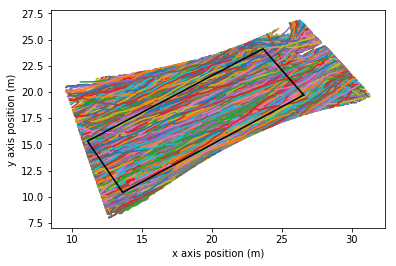

In [11]:
# Show the filtering
for o in objects:
    if(o.getUserType() == 2):
        o.plot()
drawZone(crosswalkZone)

pyplot.xlabel('x axis position (m)')
pyplot.ylabel('y axis position (m)')
# pyplot.savefig('Donnees/Donnees_produites/Figures/trajectoires_post-filtering.eps', format='eps')
pyplot.show()

### Voronoï diagram technique

In [12]:
# Function found at: https://gist.github.com/pv/8036995
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates of input vertices, with 'points at infinity' 
        appended to the end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [13]:
# https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

In [14]:
def extractCoordinatesAndSpeeds(frame):
    points = np.array([[0,0]])
    speed = []
    
    for o in objects:
        
        # Only extract data from objects that are in the desired frame
        if(o.existsAtInstant(frame)):
            
            pos = o.getPositionAtInstant(frame)
            point = Point(pos[0], pos[1])

            if(limitBox.contains(point)):
                # Coordinates of the object at the given frame
                points = np.append(points, [o.getPositionAtInstant(frame).aslist()], axis = 0)
                # Speed of the object at the given frame
                speed.append(o.getVelocityAtInstant(frame).norm2()*frameRate)
    
    if(len(points) > 15):
        points = points[1:]
    
    else:
        points = []
        speed  = []
    
    return points, speed

In [15]:
def voronoiDiagramAndDensity(points, showPlot):
    # Minimum and maximum values of the polygon areas for normalization
    minima = 0
    maxima = 30

    density = []

    # Normalize the chosen colormap
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    for region in regions:
        # Define the polygon (local area) of the point
        polygon = vertices[region]
        poly = Polygon(polygon)

        # Define limits according to the study area
        poly = poly.intersection(limitBox)
        polygon = [p for p in poly.exterior.coords]
        
        if(showPlot):
            # Fill each polygon with a color, according to the area of the region
            pyplot.fill(*zip(*polygon), color = mapper.to_rgba(PolygonArea(polygon)))

        # Calculate the local density of th point
        density.append(1/PolygonArea(polygon))
    
    if(showPlot):
        pyplot.gca().set_aspect('equal', adjustable='box') # Square plot figure
        pyplot.plot(points[:, 0], positionList[:, 1], 'ko') # Plot the points on the map
        pyplot.savefig('Donnees/Donnees_produites/Figures/diagramme_voronoi.eps', format='eps')
        pyplot.show()
    
    return density

### Tests...

In [185]:
def pedestrianIdSpeedsCoordinates(frame):
    pedestrianID = []
    speed = []

    objectsCoordinatesInFrame = np.array([[0,0]])

    for o in objects:

        if(o.existsAtInstant(frame)):
            coordinates = o.getPositionAtInstant(frame)
            point = Point(coordinates[0], coordinates[1])

            if(limitBox.contains(point)):
                speed.append(o.getVelocityAtInstant(frame).norm2()*frameRate)
                pedestrianID.append(o.getNum())
                objectsCoordinatesInFrame = np.append(objectsCoordinatesInFrame, 
                                                      [o.getPositionAtInstant(frame).aslist()], axis = 0)

    objectsCoordinatesInFrame = objectsCoordinatesInFrame[1:]
    
    return pedestrianID, speed, objectsCoordinatesInFrame

In [201]:
def voronoiCalculateDensity(points, showPlot):
    # Minimum and maximum values of the polygon areas for normalization
    minima = 0
    maxima = 20

    density = []

    # Normalize the chosen colormap
    norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)

    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    for region in regions:
        # Define the polygon (local area) of the point
        polygon = vertices[region]
        poly = Polygon(polygon)

        # Define limits according to the study area
        poly = poly.intersection(limitBox)
        polygon = [p for p in poly.exterior.coords]

        if(showPlot):
            # Fill each polygon with a color, according to the area of the region
            pyplot.fill(*zip(*polygon), color = mapper.to_rgba(PolygonArea(polygon)))

        # Calculate the local area of the point
        density.append(1/(PolygonArea(polygon)))

    if(showPlot):
        pyplot.gca().set_aspect('equal', adjustable='box') # Square plot figure
        pyplot.plot(points[:, 0], points[:, 1], 'ko') # Plot the points on the map
        pyplot.xlabel('x axis position (m)')
        pyplot.ylabel('y axis position (m)')
        pyplot.savefig('Donnees/Donnees_produites/Figures/diagramme_voronoi.eps', format='eps')
        pyplot.show()
    
    return density

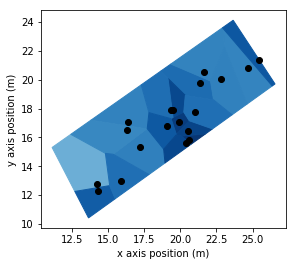

In [203]:
# pedestrianIdList, pedestrianSpeedList, pedestrianCoordinatesList = pedestrianIdSpeedsCoordinates(1500)
# objectsInFrameDensityList = voronoiCalculateDensity(pedestrianCoordinatesList, True)

In [241]:
limits = [[13.63432438, 10.42007836], [11.10970868, 15.3030904], [23.66035494, 24.12047218], [26.56081587, 19.70467278]]
limitBox = Polygon(limits)

colPedestrianPoints = ['pedestrianID', 'coordinate', 'speed', 'density', 'frame']
pedestrianPoints = pd.DataFrame(columns = colPedestrianPoints)

In [242]:
phaseFirstFrameNums

{'1014AM_July 11_2014(E to W).MP4': 840,
 '1041AM_July 11_2014(E to W).MP4': 2580,
 '1107AM_July 11_2014(E to W).MP4': 1560,
 '1133AM_July 11_2014(E to W).MP4': 480,
 '1159AM_July 11_2014(E to W).MP4': 1950,
 '1225AM_July 11_2014(E to W).MP4': 1140}

In [243]:
firstGreen = phaseFirstFrameNums['1014AM_July 11_2014(E to W).MP4'] + 15*frameRate

In [244]:
frameRate = 30 #fps
cycle = 90*frameRate # 90 s
greenTime = 40*frameRate # 40 s

In [245]:
samples = []

sampleTime = 150 #5 seconds intervals
lastFrame  = objects[-1].getLastInstant()

for greenTimes in range(firstGreen, lastFrame, cycle):
    for sample in range(greenTimes, greenTimes + greenTime - 15*frameRate, sampleTime):
        samples.append(sample)

In [247]:
for frame in samples:
    worked = True
    
    try:
        pedestrianIdList, pedestrianSpeedList, pedestrianCoordinatesList = pedestrianIdSpeedsCoordinates(frame)
        objectsInFrameDensityList = voronoiCalculateDensity(pedestrianCoordinatesList, False)
    
    except:
        worked = False
    
    if(worked):
        for i in range(len(pedestrianIdList)):
            df = pd.DataFrame([[pedestrianIdList[i], pedestrianCoordinatesList[i].tolist(), pedestrianSpeedList[i], 
                                objectsInFrameDensityList[i], frame]], 
                              columns = colPedestrianPoints)
            pedestrianPoints = pedestrianPoints.append(df, ignore_index = True)

In [253]:
pedestrianPoints.head()

,pedestrianID,coordinate,speed,density,frame
0,39,"[20.000966666666667, 16.5796]",1.989379,0.131290,1290
1,46,"[24.71780909090909, 21.427]",1.737503,0.120514,1290
2,47,"[16.76546666666667, 18.854333333333333]",1.969994,0.237370,1290
3,57,"[19.975422727272726, 18.920122727272727]",1.936668,0.109771,1290
4,61,"[17.684753333333337, 17.27361]",1.708103,0.201869,1290


In [248]:
v = pedestrianPoints.speed.tolist()
k = pedestrianPoints.density.tolist()
q = []

for i in range(len(k)):
    q.append(v[i] * k[i])

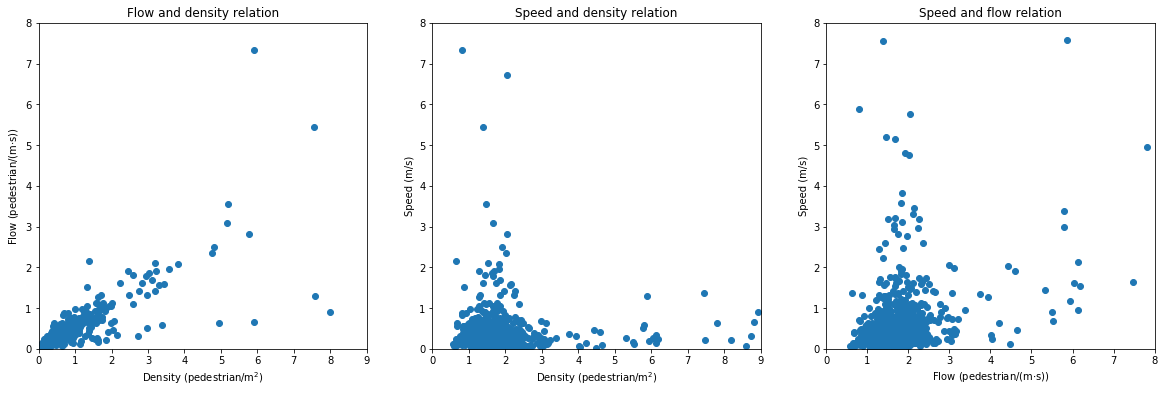

In [257]:
maxV = 8
maxK = 9
maxQ = 8

pyplot.figure(figsize=(20,6))

pyplot.subplot(131)
pyplot.scatter(q, k)
pyplot.title('Flow and density relation')
pyplot.xlabel(r'Density (pedestrian/m$^{2}$)')
pyplot.ylabel(r'Flow (pedestrian/(m$\cdot$s))')
pyplot.axis([0, maxK, 0, maxQ])

pyplot.subplot(132)
pyplot.scatter(v, k)
pyplot.title('Speed and density relation')
pyplot.xlabel(r'Density (pedestrian/m$^{2}$)')
pyplot.ylabel('Speed (m/s)')
pyplot.axis([0, maxK, 0, maxV])

pyplot.subplot(133)
pyplot.scatter(v, q)
pyplot.title('Speed and flow relation')
pyplot.xlabel(r'Flow (pedestrian/(m$\cdot$s))')
pyplot.ylabel('Speed (m/s)')
pyplot.axis([0, maxQ, 0, maxV])

pyplot.savefig('Donnees/Donnees_produites/Figures/diagrammes_fondamentaux_voronoi.eps', format='eps')

pyplot.show()

In [ ]:
i = 0

for o in objects:
    
    if(o.existsAtInstant(frame)):
        coordinates = o.getPositionAtInstant(frame)
        point = Point(coordinates[0], coordinates[1])
        
        if(limitBox.contains(point)):
            speed = o.getVelocityAtInstant(frame).norm2()*frameRate
            pedestrianID = o.getNum()
            objectsCoordinatesInFrame = np.append(objectsCoordinatesInFrame, [o.getPositionAtInstant(frame).aslist()], 
                                                  axis = 0)
            
            # Create a dataframe row to be appended
            df = pd.DataFrame([[pedestrianID, coordinates, speed, area[i], frame]], columns = colPedestrianPoints)
            pedestrianPoints = pedestrianPoints.append(df, ignore_index = True)
            
            i += 1

pedestrianPoints

In [ ]:
videoFinalFrame = objects[-1].getLastInstant()

allObservedSpeeds  = []
allObserveddensity = []

In [ ]:
# positionList, speedListToAppend = extractCoordinatesAndSpeeds(1500)
# densityListToAppend = voronoiDiagramAndDensity(positionList, True)

In [ ]:
for frameNum in range(0,10000,30):
    positionList, speedListToAppend = extractCoordinatesAndSpeeds(frameNum)
    
    # There needs to be more than 15 point in the map
    if(len(positionList) > 15):
        densityListToAppend = voronoiDiagramAndDensity(positionList, False)
        
        if(len(speedListToAppend) == len(densityListToAppend)):
            allObservedSpeeds  += speedListToAppend
            allObserveddensity += densityListToAppend

In [ ]:
v = allObservedSpeeds
k = allObserveddensity
q = []

for i in range(len(k)):
    q.append(v[i] * k[i])

In [ ]:
pyplot.figure(figsize=(20,6))

pyplot.subplot(131)
pyplot.scatter(q, k)
pyplot.title('Relation entre le débit et la densité')
pyplot.xlabel(r'Densité (piéton/m$^{2}$)')
pyplot.ylabel(r'Débit (piéton/(m$\cdot$s))')
pyplot.axis([0, 10000, 0, 2000])

pyplot.subplot(132)
pyplot.scatter(v, k)
pyplot.title('Relation entre la vitesse et la densité')
pyplot.xlabel(r'Densité (piéton/m$^{2}$)')
pyplot.ylabel('Vitesse (m/s)')
pyplot.axis([0, 15, 0, 2000])

pyplot.subplot(133)
pyplot.scatter(v, q)
pyplot.title('Relation entre la vitesse et le débit')
pyplot.xlabel(r'Débit (piéton/(m$\cdot$s))')
pyplot.ylabel('Vitesse (m/s)')
pyplot.axis([0, 15, 0, 2000])

pyplot.savefig('Donnees/Donnees_produites/Figures/diagrammes_fondamentaux_voronoi.eps', format='eps')

pyplot.show()

### Edie's definition extension

In [ ]:
def objectsAppearingBetweenFrames(frameMin, frameMax):
    objectsAppearingBetweenFrames = []

    for o in objects:
        objectTrajectoryFirstFrame = o.getFirstInstant()
        objectTrajectoryLastFrame  = o.getLastInstant()

        # The trajectory of the object is, at some point, between the first and the last sampled frame
        if(objectTrajectoryFirstFrame < frameMax and objectTrajectoryLastFrame > frameMin):
            objectNumber = o.getNum()

            if(objectNumber not in objectsAppearingBetweenFrames):
                objectsAppearingBetweenFrames.append(objectNumber)
    
    return objectsAppearingBetweenFrames

In [ ]:
def pointIsInBox(objectID, frame, limitBox):
    pos   = objects[objectID].getPositionAtInstant(frame) # X et Y coordinates at the given frame
    point = Point(pos[0], pos[1])

    return limitBox.contains(point)

In [ ]:
def findEntries(limitBox, firstFrame, lastFrame, objectsPresent):
    # Initialize the DataFrame for the first moment in the volume
    colEntries = ['trajectoryID', 'coordinateInit', 'frameInit']
    entries = pd.DataFrame(columns = colEntries)

    # Iterate from first to the last studied frame
    for frame in range(firstFrame, lastFrame + 1):

        # Find the objects that are present in the frame
        for objectNum in objectsPresent:

            # Check if the trajectory is in the frame
            if(objects[objectNum].existsAtInstant(frame)):

                # Check if the trajectory is new
                if(objectNum not in entries.trajectoryID.tolist()):

                    # Check wether the point is in the limits of the study area
                    if(pointIsInBox(objectNum, frame, limitBox)):
                        firstCoordinates = objects[objectNum].getPositionAtInstant(frame)

                        # Create a dataframe row to be appended
                        df = pd.DataFrame([[objectNum, firstCoordinates, frame]], columns = colEntries)
                        entries = entries.append(df, ignore_index = True) # Append the new row
    return entries

In [ ]:
def findExits(limitBox, entriesList):
    # Initialize the DataFrame for the last moment in the volume
    colExits = ['trajectoryID', 'coordinateLast', 'frameLast']
    exits = pd.DataFrame(columns = colExits)

    for objectNum in entriesList:
        lastFrame = objects[objectNum].getLastInstant()
        lastPos   = objects[objectNum].getPositionAtInstant(lastFrame)

        # Case where the trajectory ends in the area
        if(pointIsInBox(objectNum, lastFrame, limitBox)):
            lastCoordinates = lastPos

        # The trip ends out of bound
        else:
            # Finding the last coordinates that were in the area
            while(not pointIsInBox(objectNum, lastFrame, limitBox)):
                lastFrame -= 1

            lastCoordinates = objects[objectNum].getPositionAtInstant(lastFrame)

        df = pd.DataFrame([[objectNum, lastCoordinates, lastFrame]], columns = colExits)
        exits = exits.append(df, ignore_index = True) # Append the new row
    return exits

In [ ]:
def computeDistance(trajID, entries, exits):
    # Find the dataframe corresponding to the desired ID
    trajectoryEntryDataFrame = entries.loc[entries.trajectoryID == trajID]
    trajectoryExitDataFrame  = exits.loc[exits.trajectoryID == trajID]
    
    # Extract the first and final positions
    x_ini = trajectoryEntryDataFrame.coordinateInit.values[0][0]
    y_ini = trajectoryEntryDataFrame.coordinateInit.values[0][1]

    x_las = trajectoryExitDataFrame.coordinateLast.values[0][0]
    y_las = trajectoryExitDataFrame.coordinateLast.values[0][1]

    return math.sqrt((x_ini - x_las)**2 + (y_ini - y_las)**2)

In [ ]:
def computeTime(trajID, entries, exits):
    # Find the dataframe corresponding to the desired ID
    trajectoryEntryDataFrame = entries.loc[entries.trajectoryID == trajID]
    trajectoryExitDataFrame  = exits.loc[exits.trajectoryID == trajID]
    
    # Extract the first and final frame values
    t_ini = trajectoryEntryDataFrame.frameInit.values[0]
    t_las = trajectoryExitDataFrame.frameLast.values[0]
    
    return (t_las - t_ini) / frameRate

In [ ]:
def calculateDistanceAndTime(listOfEntries, entries, exits):
    sumOfDistances = 0
    sumOfTime      = 0

    for tID in listOfEntries:
        sumOfDistances += computeDistance(tID, entries, exits)
        sumOfTime      += computeTime(tID, entries, exits)
    
    return sumOfDistances, sumOfTime

In [ ]:
def findFlowDensitySpeed(flow, density, speed, frameMin, frameMax):
    totalDistance = 0
    totalTime     = 0

    # Find all the entry points (in area, between frames)
    objectsPresent = objectsAppearingBetweenFrames(frameMin, frameMax)
    entries = findEntries(limitBox, frameMin, frameMax, objectsPresent)

    # Find all the exit points (in area, between frames)
    entriesList = entries.trajectoryID.tolist()
    exits = findExits(limitBox, entriesList)

    XY = PolygonArea(limits)
    T  = delatT/frameRate

    totalDistance, totalTime = calculateDistanceAndTime(entriesList, entries, exits)

    flow.append(totalDistance/(T*XY))
    density.append(totalTime/(T*XY))
    speed.append(totalDistance/totalTime)
    
    return flow, density, speed

In [ ]:
frameRate = 30
delatT    = 90*frameRate # 90 s cycle with a green time of 40 s

In [ ]:
q = []
k = []
v = []

listOfIntervals = []

a = np.arange(0,46889,2700)

i = 0

while(i < len(a) - 1):
    listOfIntervals.append([a[i], a[i + 1]])
    i += 1

for a in listOfIntervals:
    firstFrame = a[0]
    lastFrame  = a[1]
    
    q, k, v = findFlowDensitySpeed(q, k, v, firstFrame, lastFrame)

In [ ]:
pyplot.figure(figsize=(20,6))

pyplot.subplot(131)
pyplot.scatter(q, k)
pyplot.title('Relation entre le débit et la densité')
pyplot.xlabel(r'Densité (piéton/m$^{2}$)')
pyplot.ylabel(r'Débit (piéton/(m$\cdot$s))')

pyplot.subplot(132)
pyplot.scatter(v, k)
pyplot.title('Relation entre la vitesse et la densité')
pyplot.xlabel(r'Densité (piéton/m$^{2}$)')
pyplot.ylabel('Vitesse (m/s)')

pyplot.subplot(133)
pyplot.scatter(v, q)
pyplot.title('Relation entre la vitesse et le débit')
pyplot.xlabel(r'Débit (piéton/(m$\cdot$s))')
pyplot.ylabel('Vitesse (m/s)')

# pyplot.savefig('Donnees/Donnees_produites/Figures/diagrammes_fondamentaux_edie.eps', format='eps')

pyplot.show()

In [ ]:
# import pickle

# # Saving the objects
# with open('Donnees/Donnees_produites/qkv_Edie.pkl', 'wb') as f:
#     pickle.dump([q, k, v], f)

In [ ]:
# # Getting back the objects:
# with open('Donnees/Donnees_produites/qkv_Edie.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
#     q, k, v = pickle.load(f)